# 0. Import tools, libraries, etc..

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
%matplotlib inline
sns.set(rc={"figure.figsize":(15.,8.)})
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

# Goal: Can we predict the price of a house based on features?

## 1. Fetch data

In [2]:
df=pd.read_csv('regression_data.csv')

Make copies of the original dataframe for models

In [3]:
df1=df.copy(deep=True)

## 2. Exploration of data EDA

In [4]:
df.shape

(21597, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   bedrooms       21597 non-null  int64  
 3   bathrooms      21597 non-null  float64
 4   sqft_living    21597 non-null  int64  
 5   sqft_lot       21597 non-null  int64  
 6   floors         21597 non-null  float64
 7   waterfront     21597 non-null  int64  
 8   view           21597 non-null  int64  
 9   condition      21597 non-null  int64  
 10  grade          21597 non-null  int64  
 11  sqft_above     21597 non-null  int64  
 12  sqft_basement  21597 non-null  int64  
 13  yr_built       21597 non-null  int64  
 14  yr_renovated   21597 non-null  int64  
 15  zipcode        21597 non-null  int64  
 16  lat            21597 non-null  float64
 17  long           21597 non-null  float64
 18  sqft_l

In [6]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,13/10/2014,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900
1,6414100192,09/12/2014,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000
2,5631500400,25/02/2015,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000
3,2487200875,09/12/2014,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000
4,1954400510,18/02/2015,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000


Check the normality of the numerical variable visually

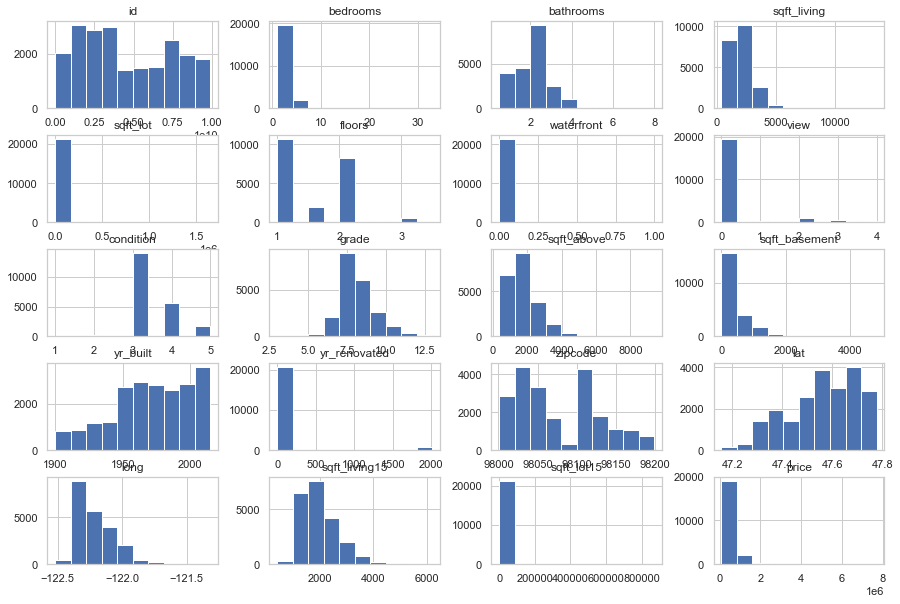

In [7]:
df.hist(figsize=(15,10));

Check correlation between features (all of them are numeric)

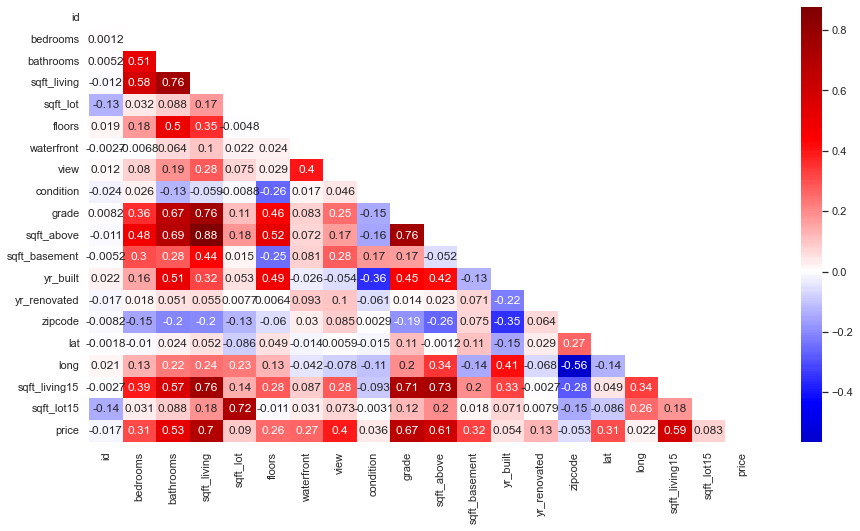

In [8]:
# correlation matrix heatmap 
mask=np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=True
sns.heatmap(df.corr(),mask=mask, annot=True,cmap='seismic',center=0);

(0.0, 8082940.977915449)

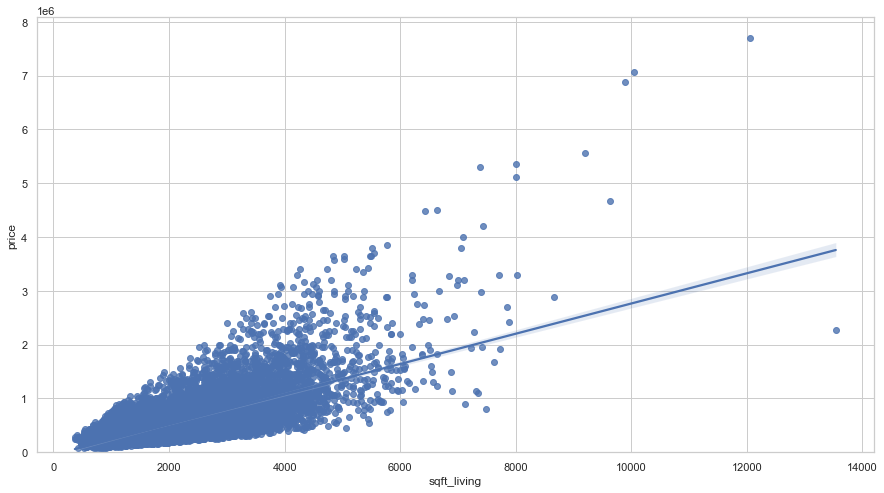

In [63]:
#check correlation, plot a trend line with the scatter (regplot)
sns.regplot(x="sqft_living", y="price", data=df)
plt.ylim(0,)

## 3. Cleaning process

In [10]:
# Check for nan values
df.isnull().values.any()

False

In [11]:
for c in df.columns:
    print(c, len(df[c].unique()))

id 21420
date 372
bedrooms 12
bathrooms 29
sqft_living 1034
sqft_lot 9776
floors 6
waterfront 2
view 5
condition 5
grade 11
sqft_above 942
sqft_basement 306
yr_built 116
yr_renovated 70
zipcode 70
lat 5033
long 751
sqft_living15 777
sqft_lot15 8682
price 3622


Looking at the id and dates we found that some houses (176) were sold twice or more times within the period of analysis

In [12]:
df1['id'].value_counts()

795000620     3
8910500150    2
7409700215    2
1995200200    2
9211500620    2
             ..
3649100387    1
2767603649    1
1446403617    1
5602000275    1
1523300157    1
Name: id, Length: 21420, dtype: int64

In [13]:
(df1['id'].value_counts()>1).sum()

176

We drop houses sold more than one time and kept the last transaction recorded for these houses 

In [14]:
# Convert column date from object to date
df1['date'] = pd.to_datetime(df1['date'])

In [15]:
# sort df by date
df1=df1.sort_values(by='date',ascending=True)

In [16]:
# Dropping duplicates based on id and geolocation - latitude and longitud. Keeping the lastest record date
df1=df1.drop_duplicates(subset=['id'], keep='last')

In [17]:
# Checking the output of previous query
df1['id'].value_counts()

3524039060    1
2780900220    1
2926049400    1
3213200314    1
1237500720    1
             ..
3432500980    1
3275300270    1
7212650950    1
1938400300    1
9358000780    1
Name: id, Length: 21420, dtype: int64

In [18]:
# Dropping an outlier based on number of bedrooms. 
# We found that the sqft_living did not match the expected sqft of a 33 bedroom house
df1=df1[df1['bedrooms']!=33]

In [19]:
# checking the output of the last query
df1['bedrooms'].unique()

array([ 1,  3,  5,  4,  2,  6,  7,  8,  9, 10, 11])

In [20]:
df1.reset_index(drop=True, inplace=True)

In [21]:
#Checking the renovated houses column. There is 914 houses renovated

In [22]:
#print(f" Percentage of renovated houses = {round((df1['yr_renovated'] !=0).sum() / sum(df1['yr_renovated'].value_counts())*100, 2)}%")

In [23]:
#Change yr_renovated column into 0 (not renovation) and 1 (renovation)
df1.loc[df1['yr_renovated'] > 1900, 'yr_renovated'] = 1

In [24]:
#df1['yr_renovated'].unique()

Drop id, date columns

In [25]:
df= df.drop(['id','date'],axis=1)
# drop id, date to run first model

In [26]:
# split data into x and y to run 1st model

# 4 Running models

# First Model

### Select target and independent features

In [27]:
y= df['price']

In [28]:
X= df.drop(['price'], axis = 1)

In [29]:
from sklearn.linear_model import LinearRegression as Lin
from sklearn.model_selection import train_test_split as tts

In [30]:
# define the model 
linreg=Lin()

In [31]:
# split the data into TT 
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=40)

In [32]:
# train the model on train 
linreg.fit(X_train,y_train)

LinearRegression()

In [33]:
#make some predictions on test 
y_pred=linreg.predict(X_test)

### Import and apply a regression mode

In [34]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 

In [35]:
r2(y_test,y_pred)


0.7068628847266576

In [36]:
mse(y_test,y_pred)


39350992633.39004

In [37]:
mae(y_test,y_pred)

125749.52431191332

## Second Model

### Running second model with rescale and dropped columns

In [38]:
df1= df1.drop(['id','date'],axis=1)

In [39]:
df1.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1,1.00,750,4000,1.0,0,0,3,6,750,0,1918,0,98136,47.5243,-122.390,1770,4850,250000
1,3,1.75,1620,7330,1.0,0,0,4,7,1090,530,1974,0,98034,47.7148,-122.213,1380,7191,459000
2,5,3.00,3640,8239,2.0,0,3,3,10,2540,1100,1982,0,98008,47.5842,-122.111,3330,10643,1600000
3,4,3.50,3480,7232,2.0,0,0,3,9,2580,900,1926,1,98144,47.5859,-122.291,2380,5642,1510000
4,3,1.75,1790,12000,1.0,0,0,3,7,1040,750,1960,0,98198,47.3945,-122.313,1840,12000,243000


### Rescale the features

In [40]:
df1.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

In [41]:
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'price']

In [42]:
from sklearn import preprocessing
min_max = preprocessing.MinMaxScaler()
df1[columns] = min_max.fit_transform(df1[columns])

# Select target and independent features

In [43]:
y= df1['price']

In [44]:
X= df1.drop(['price'], axis = 1)

# Import and apply a regression model

In [45]:
from sklearn.linear_model import LinearRegression as Lin
from sklearn.model_selection import train_test_split as tts

In [46]:
# define the model 
linreg=Lin()

In [47]:
# split the data into TT 
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=40)

In [48]:
# train the model on train 
linreg.fit(X_train,y_train)

LinearRegression()

In [49]:
#make some predictions on test 
y_pred=linreg.predict(X_test)

In [50]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_error as mae 

In [51]:
r2(y_test,y_pred)

0.6914579571476409

In [52]:
mse(y_test,y_pred)

0.0006285176947899138

In [53]:
mae(y_test,y_pred)

0.016362058136686574

## Third Model

### KNN regression

In [54]:
y= df1['price']

In [55]:
X= df1.drop(['price'], axis = 1)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=40)

In [68]:
from sklearn.neighbors import KNeighborsRegressor
neigh=KNeighborsRegressor(n_neighbors=4)

In [69]:
neigh.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=4)

In [73]:
y_pred_knn=neigh.predict(X_test)

In [74]:
neigh.fit(X_train,y_train)

KNeighborsRegressor(n_neighbors=4)

In [75]:
r2(y_test,y_pred) 

0.7864444650313809

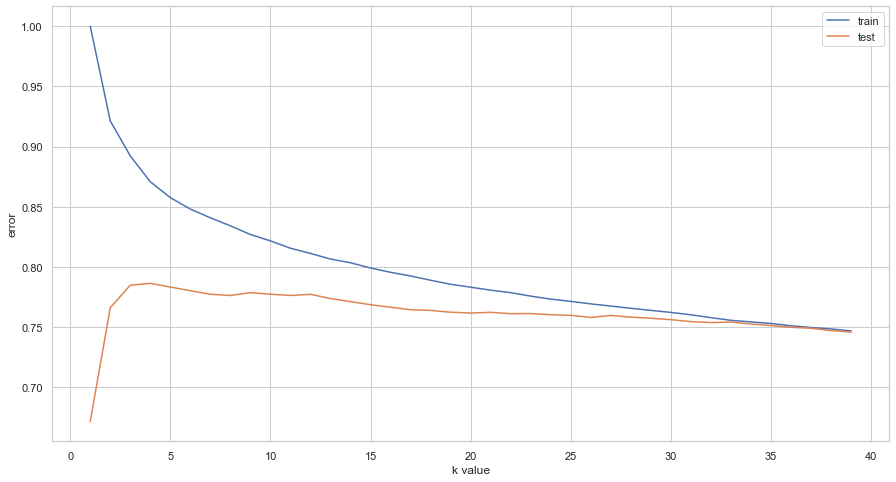

In [76]:
error_train=[]
error_test=[]
for k in range(1,40):
    knn=KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train,y_train)
    y_pred1=knn.predict(X_train)
    error_train.append(r2(y_train,y_pred1)) # or append accuracy_score(y_test,y_pred)
    y_pred2=knn.predict(X_test)
    error_test.append(r2(y_test,y_pred2))
plt.plot(range(1,40),error_train,label='train')
plt.plot(range(1,40),error_test,label='test')
plt.xlabel('k value')
plt.ylabel('error')
plt.legend();

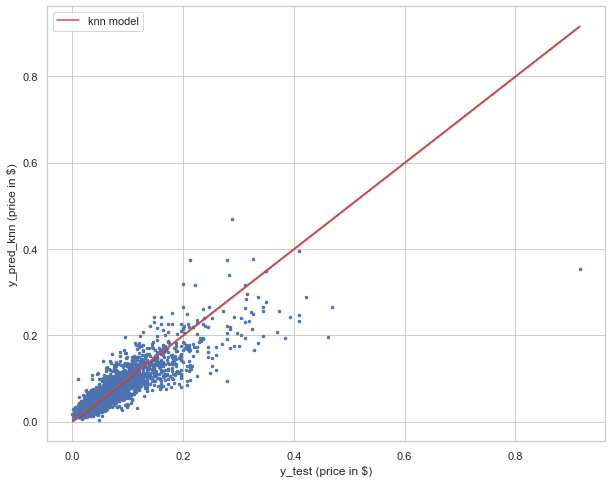

In [78]:
# generating value pairs for an ideal model which predicts the exact same y-value for a given test-y-value
line_x = line_y = np.linspace(min(y_test), max(y_test), num=len(y_test))
fig, ax = plt.subplots(figsize=(10,8))
plt.plot(y_test, y_pred, ms=5, marker=".", ls='')
# plot the ideal model together with our dots
plt.plot(line_x, line_y, ms=0.1, marker=".", ls='-', c='r', label='knn model')
# show legend
plt.legend();
plt.xlabel('y_test (price in $)');
plt.ylabel('y_pred_knn (price in $)');

# 5. Results
The first test before pre-processing and cleaning had a result of 70%. Our best performance was with the KNN regression model. We applied the model after pre-processing using MinMax Scaler method and cleaning the data, with an accuracy score of 78,6%.
